# 6 Hour Forecast using Dynamic Graph

In [1]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp
import networkx
import torch_geometric
import torch
from torch_geometric.utils.convert import from_networkx

## Initialize
1. Chunk Properly (dataframe available at https://drive.google.com/drive/folders/1CwSLAJeCGUuHXRJOZ9YgkraHYaE8pGGH?usp=sharing)
2. Load aggregated
3. Load window csv with lclids corresponding to aggregated data

In [2]:
# load the data
file = open('uk_smart_meter_aggregated/df_agg.pkl','rb')
df_agg = pickle.load(file)
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2012-01-01 00:00:00 to 2013-12-31 23:00:00
Columns: 5558 entries, 2 to 5564
dtypes: float64(5558)
memory usage: 744.1 MB


In [3]:
file = open('uk_smart_meter_aggregated/windows_agg_ids.pkl','rb')
windows = pickle.load(file)
windows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558 entries, 0 to 5557
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   LCLid        5558 non-null   int64          
 1   Enabled At   5558 non-null   datetime64[ns] 
 2   Disabled At  5558 non-null   datetime64[ns] 
 3   Duration     5558 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 217.1 KB


## Snapshot-based temporal graph
Idea: Build the adjacency matrix for all nodes using `create_adjacency_matrix`. Select a time-stamp for example [0]: '2012-01-01 00:00:00' or [1]: '2012-01-01 01:00:00' and so on. For this time-stamp what all nodes are active? Make an adjacency matrix for only these nodes for that particular time stamp using `get_snapshot_adjacency`. This function further returns the LCLids of active nodes (2,3,... 5564) and the indices of those active nodes (dataframe indices as in from range 0 to 5557).

1. Get the adjacency matrix for *all the nodes* at once to avoid computation

Number of unique start dates:  2154
Graph connected for k=50: True
sparsity:  0.9439180477754235


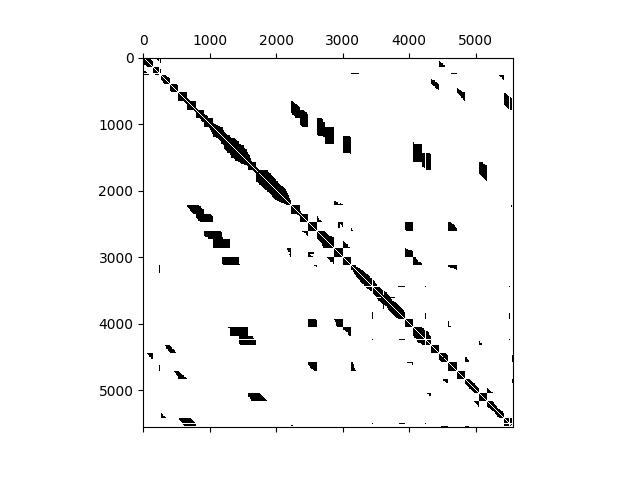

In [16]:
def create_adjacency_matrix(lclids, k):
    number_of_nodes = sum([len(l) for l in lclids])
    adjacency_matrix = np.zeros((number_of_nodes, number_of_nodes))
    # Create the graph by iterating over the list of lists of LCLids
    # and connecting all nodes in the list with each other
    # and with the k-nearest lists
    for i in range(len(lclids)): # range 2156
        for j in range(len(lclids)): # range 2156 
            if i == j: 
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
            elif abs(i-j) <= k:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
    adjacency_matrix = adjacency_matrix - np.eye(number_of_nodes)
    return sp.sparse.bsr_array(adjacency_matrix)
    
# Sort rows by start date
windows_copy = windows.sort_values(by='Enabled At').copy()

# Get an ordered list of dates 'Enabled At'
enable_unique_dates = windows_copy['Enabled At'].unique()

# Get a list of lists of LCLids that have the same start date
nbor_lclids = [windows_copy[windows_copy['Enabled At'] == date].index.tolist() for date in enable_unique_dates]
print('Number of unique start dates: ', len(enable_unique_dates))
assert len(windows) == sum([len(l) for l in nbor_lclids])

# K-nearest neighbours
k = 50

adjacency_matrix = create_adjacency_matrix(nbor_lclids, k)
# Compute the sparsity of the adjacency matrix
sparsity = 1 - sp.sparse.bsr_matrix.count_nonzero(adjacency_matrix) / np.prod(adjacency_matrix.shape)
G = networkx.from_scipy_sparse_array(adjacency_matrix)
print(f'Graph connected for k={k}: {networkx.is_connected(G)}')
print('sparsity: ', sparsity)

plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
# save the adjacency matrix
np.save('Results/adjacency_matrix.npy', adjacency_matrix)
plt.show()

2. Make a function to get the sub-adjacency matrix for all nodes active at a given time instant

In [5]:
def get_snapshot_adjacency(timestampidx, full_adjacency_matrix, df_agg):
    """
    timestampidx: Time index; For example [0]: '2012-01-01 00:00:00'
    full_adjacency_matrix (np.array()): adjacency matrix for all the LCLids
    df_agg: aggregated dataframe with timeseries for all LCLids 
    
    Returns:
    indices_active_nodes: dataframe indices of active nodes
    active nodes: LCLids of active nodes 
    active_sparse_submat: adjacency matrix obtained for that particular timestamp (using timestampidx)
    """
    full_adjacency_matrix = full_adjacency_matrix.toarray()

    # get all the active nodes for that particular time-stamp
    active_nodes = df_agg.columns[df_agg.loc[df_agg.index[timestampidx], :].notna()]
    
    # indices of active nodes
    indices_active_nodes = windows[windows['LCLid'].isin(active_nodes.values)].index

    # active nodes sub-adjacency matrix
    active_adj_submat = full_adjacency_matrix[np.ix_(indices_active_nodes, indices_active_nodes)]

    if active_adj_submat.shape[0] != active_nodes.shape[0]:
        print(f'# active nodes = {active_nodes.shape}, while \
        Adjacency Matrix Shape = {active_adj_submat.shape}')
        raise RuntimeError()

    # create graph from the adjacency submatrix to check if it is connected
    active_sparse_submat = sp.sparse.bsr_array(active_adj_submat)
    
    G = networkx.from_scipy_sparse_array(active_sparse_submat)

    # check if the graph is fully connected
    assert networkx.is_connected(G)

    # FOR FURTHER ANALYSIS
    #sparsity_submat = 1 - sp.sparse.bsr_matrix.count_nonzero(active_sparse_submat) \
    #/ np.prod(active_sparse_submat.shape)
    #print(f'Sparsity = {sparsity_submat}')
    
    
    # get edge indices from the adjacency submatrix COO Format
    # edge_index = torch.tensor(np.array(G.edges).T)

    # node feature matrix 
    # x = torch.tensor(df_agg.loc[df_agg.index[100],activenodes].values).view(-1,1)
    return indices_active_nodes, active_nodes, active_sparse_submat


# example usage:
indices, activenodes, active_sparse_submat = get_snapshot_adjacency(100, adjacency_matrix, df_agg) # check exact date using df_agg.index[100]

## Produce Graph from Contiguous Snapshots - Supra Adjacency Matrix

Idea: Take $n$ snapshots and extract the sub-adjacency matrix for all these time-stamps. Make a product graph using spatial temporal coupling for all these snapshots.

In [6]:
print(f'Snapshots taken at {df_agg.index[0]}, {df_agg.index[50]}, {df_agg.index[100]} to calculate the supra adjacency matrix') 

Snapshots taken at 2012-01-01 00:00:00, 2012-01-03 02:00:00, 2012-01-05 04:00:00 to calculate the supra adjacency matrix


In [38]:
def get_subadj_book(window_idx, adjacency_matrix, df_agg):
    """
    Input: 
        - window index (for eg., range(0,23) for first 24 hours)
        - full adjacency matrix 
        - aggregated dataframe 
    Returns 
        - index (of dataframe) book of all active nodes throughout the window for all time instances
        - LCLids of active nodes throughout the window for all time instances
        - subadjacency matrix throughout the window for all time instances
        - LCLids of all active unique nodes inside the window_idx
    """
    subadj_book = {}
    idx_book = {}
    actnod_book = {}
    all_nodes = {}
    for i in window_idx:
        # extract the subadjacency matrix at i-th time-stamp
        idx_i, actnod_i, subadj_i = get_snapshot_adjacency(i, adjacency_matrix, df_agg)
        idx_book[i] = idx_i
        actnod_book[i] = actnod_i
        subadj_book[i] = subadj_i.toarray()
        
        # Union of nodes in all snapshots
        # EX: snapshot 1 nodes: {3,2,1}; snapshot 2 nodes: {2,3,4}; snapshot 3 nodes: {1,5,6}
        # all nodes = {3,2,1,4,5,6}
        all_nodes = set(all_nodes).union(set(idx_i))
    return idx_book, actnod_book, subadj_book, all_nodes

window_idx = np.arange(24) # training window for first 24 hours
# extract the subadjacency matrix for all those time-stamps
idx_book, actnod_book, subadj_book, all_nodes = get_subadj_book(window_idx, adjacency_matrix, df_agg)

### Need to change below code for entire time window

In [40]:
# create node index mapping
# index_mapping = {0,1,2,3,4,5} for sorted nodes {1,2,3,4,5,6}
node_index_map = {node: i for i, node in enumerate(sorted(all_nodes))}

# total nodes = 6
num_nodes = len(node_index_map)

# Align Adjacency Matrices
# Construct aligned adjacency matrices for each snapshot
# based on the union of all nodes.
# By align I mean match the dimensions of all three snapshots. 
# snapshot 1: (410, 410) >> (698, 698), snapshot 2: (491, 491) >> (698, 698) 
# 698 is the number of union nodes which in our case is same as the number of active nodes of 3rd time-stamp
def align_adjacency_matrix(active_nodes, subadj, all_nodes, node_index_map):
    subadj = subadj.toarray()
    aligned_subadj = np.zeros((len(all_nodes), len(all_nodes)))
    for i, node_i in enumerate(active_nodes):
        for j, node_j in enumerate(active_nodes):
            if node_i in node_index_map and node_j in node_index_map:
                idx_i = node_index_map[node_i]
                idx_j = node_index_map[node_j]
                aligned_subadj[idx_i, idx_j] = subadj[i, j]
    
    return aligned_subadj

aligned_subadj1 = align_adjacency_matrix(actnod1, subadj1, all_nodes, node_index_map)
aligned_subadj2 = align_adjacency_matrix(actnod2, subadj2, all_nodes, node_index_map)
aligned_subadj3 = align_adjacency_matrix(actnod3, subadj3, all_nodes, node_index_map)

In [41]:
aligned_subadj1.shape[0]

410

Build a supra-adjacency matrix for $n$ time instances using spatio-temporal coupling. Note: we cannot use the kronecker product here since at all instances, the adjacnecy matrix `aligned_subadj1/2/3` is different. 

In [12]:
def supra_adjacency_matrix(stacked_aligned_subadj):
    # time instances
    instances = stacked_aligned_subadj.shape[2]

    # size of aligned
    a_size = stacked_aligned_subadj.shape[0]

    # supra 
    S = np.zeros((a_size*instances, a_size*instances))

    # Place aligned at appropriate locations for spatio-temporal coupling
    # temporal + own-node spatial component
    for i in range(1,instances):
        S[i*a_size:(i+1)*a_size, (i-1)*a_size:i*a_size] = stacked_aligned_subadj[...,i-1] + np.eye(a_size) # last term is own-node spatial component
    # spatial coupling
    for i in range(instances):
        S[i*a_size:(i+1)*a_size, i*a_size:(i+1)*a_size] = stacked_aligned_subadj[...,i]
    
    return S

# Need functions for stacking...
stacked_aligned_subadj = np.stack([aligned_subadj1, aligned_subadj2, aligned_subadj3], axis=-1)
supra_adj_mat = supra_adjacency_matrix(stacked_aligned_subadj)

In [13]:
supra_adj_mat.shape

(2094, 2094)

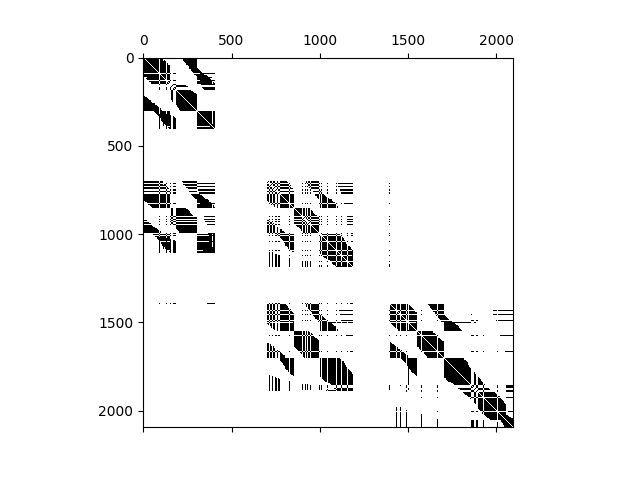

In [18]:
fig, ax = plt.subplots()
plt.spy(supra_adj_mat)
plt.show()